In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
def dtype_compressor(df):
  #object 
  # when unique ratio > 0.5, catogory stands less memory than object
  converted_obj = pd.DataFrame()
  df_obj = df.select_dtypes(include=['object'])
  for col in df_obj.columns:
    converted_obj.loc[:,col] = df_obj.loc[:,col].astype('category')

  # numbers
  df_down_num = pd.DataFrame()
  df_num = df.select_dtypes(include=['number'])
  for col in df_num.columns:
    df_down_num.loc[:,col] = pd.to_numeric(df_num.loc[:,col],downcast='signed')

  # merge
  df = pd.concat([converted_obj,df_down_num],axis=1)
  
  del converted_obj, df_obj, df_down_num, df_num  
  
  return df

In [3]:
def fast_datetime(s):
    dates = {date:pd.to_datetime(date,format='%Y%m%d') for date in s.unique()}
    return s.map(dates)

In [4]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Load Csv 

##### train.csv & train_v2.csv

In [5]:
KKboxTrainV1 = pd.read_csv('./RawData/train.csv')
KKboxTrainV2 = pd.read_csv('./RawData/train_v2.csv')

In [6]:
# 合併
KKboxTrain = pd.concat([KKboxTrainV1, KKboxTrainV2], axis=0)

In [7]:
del KKboxTrainV1, KKboxTrainV2

In [8]:
print(KKboxTrain.shape)
KKboxTrain.head()

(1963891, 2)


,msno,is_churn
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1


##### members_v3.csv

In [9]:
KKboxMembers = pd.read_csv('./RawData/members_v3.csv')

In [10]:
print(KKboxMembers.shape)
KKboxMembers.head()

(6769473, 6)


,msno,city,bd,gender,registered_via,registration_init_time
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,NaN,11,20110911
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,20110914
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,NaN,11,20110915
3,9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,1,0,NaN,11,20110915
4,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,female,9,20110915


##### transactions.csv & transactions_v2.csv

In [11]:
KKboxTransacV1 = pd.read_csv('./RawData/transactions.csv')
KKboxTransacV2 = pd.read_csv('./RawData/transactions_v2.csv')

In [12]:
KKboxTransac = pd.concat([KKboxTransacV1, KKboxTransacV2], axis=0)

In [13]:
del KKboxTransacV1, KKboxTransacV2

# Data Preprocessing

* 原本Data Preprocessing第一步要進行缺失值處理，因為要將幾份資料表進行合併處理，缺失值待後續進行。
* 由於Transaction與Train、Members無法直接合併，所以先合併Train與Members，後續再將Transaction萃取新特徵合併進來

##### 合併Train與Members

In [14]:
KKboxTrainMembers = pd.merge(KKboxTrain, KKboxMembers, how='inner', on='msno')

In [15]:
print(KKboxTrainMembers.shape)
KKboxTrainMembers.head()

(1738128, 7)


,msno,is_churn,city,bd,gender,registered_via,registration_init_time
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1,18,36,female,9,20050406
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,10,38,male,9,20050407
2,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,10,38,male,9,20050407
3,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1,11,27,female,9,20051016
4,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1,13,23,female,9,20051102


In [16]:
KKboxTrainMembers.isnull().sum()

msno                           0
is_churn                       0
city                           0
bd                             0
gender                    957531
registered_via                 0
registration_init_time         0
dtype: int64

In [17]:
len(KKboxTrainMembers[KKboxTrainMembers['gender'].isnull()]) / len(KKboxTrainMembers)

0.5508978625279611

* 小結：合併train與members後，特徵gender含缺失值，佔所有資料約55%比例

##### 處理缺失值

因為gender缺失值達55%，直接去除缺失值欄位會造成許多有用的資料流失，故在此將gender缺失值分成另外一類，同時將male與female做one-hot encoding

In [18]:
# 對male與female做one-hot encoding
gender_encode = {'male':'1', 'female':'0'}
KKboxTrainMembers['gender'] = KKboxTrainMembers['gender'].map(gender_encode)

In [19]:
KKboxTrainMembers['gender'] = KKboxTrainMembers['gender'].fillna('-1')

##### 處理不合理值

由於觀察bd(年齡)發現出現不合理值(eg.1040歲、-48歲)，需要做處理

In [20]:
# 取12歲~100歲
KKboxTrainMembers = KKboxTrainMembers[KKboxTrainMembers['bd'] > 12]
KKboxTrainMembers = KKboxTrainMembers[KKboxTrainMembers['bd'] < 100]

##### 處理日期型態

In [21]:
d = ['registration_init_time']
for col in d:
  KKboxTrainMembers[col] = fast_datetime(KKboxTrainMembers[col])

##### 確認各欄位型態

In [22]:
KKboxTrainMembers.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 775532 entries, 0 to 1738126
Data columns (total 7 columns):
msno                      775532 non-null object
is_churn                  775532 non-null int64
city                      775532 non-null int64
bd                        775532 non-null int64
gender                    775532 non-null object
registered_via            775532 non-null int64
registration_init_time    775532 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 156.0 MB


In [23]:
KKboxTrainMembers.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1,18,36,0,9,2005-04-06
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,10,38,1,9,2005-04-07
2,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,10,38,1,9,2005-04-07
3,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1,11,27,0,9,2005-10-16
4,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1,13,23,0,9,2005-11-02


##### 觀察前處理後資料(可視化確認)

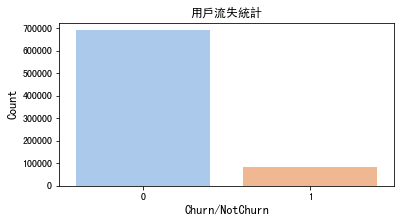

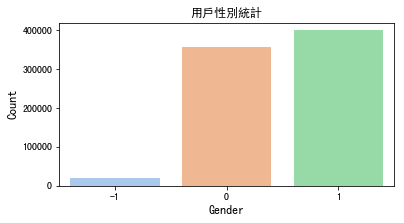

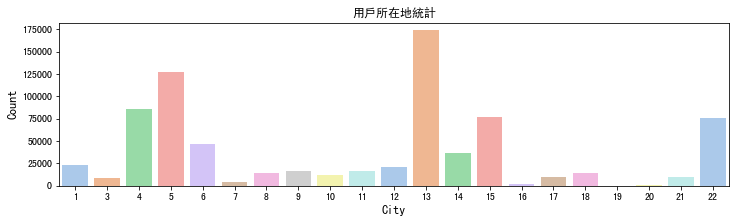

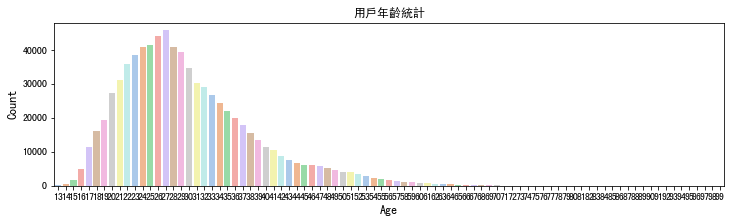

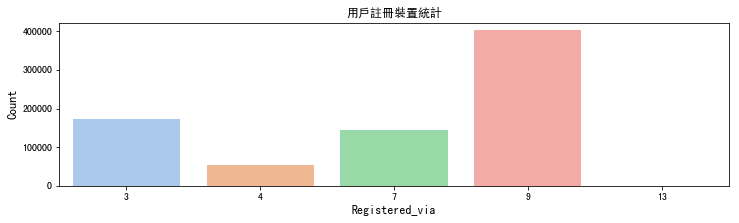

In [24]:
# is_churn
plt.figure(figsize=(6,3))
# plt.figure(figsize=(6,3))
sns.countplot(x="is_churn", data=KKboxTrainMembers, palette = "pastel")
plt.ylabel('Count', fontsize=12)
plt.xlabel('Churn/NotChurn', fontsize=12)
plt.title('用戶流失統計', fontsize=12)
plt.show()

# gender
plt.figure(figsize=(6,3))
sns.countplot(x='gender', data=KKboxTrainMembers, palette = "pastel")
plt.ylabel('Count', fontsize=12)
plt.xlabel('Gender', fontsize=12)
plt.title('用戶性別統計', fontsize=12)
plt.show()

# city
plt.figure(figsize=(12,3))
sns.countplot(x='city', data=KKboxTrainMembers, palette = "pastel")
plt.ylabel('Count', fontsize=12)
plt.xlabel('City', fontsize=12)
plt.title('用戶所在地統計', fontsize=12)
plt.show()

# bd
plt.figure(figsize=(12,3))
sns.countplot(x='bd', data=KKboxTrainMembers, palette = "pastel")
plt.ylabel('Count', fontsize=12)
plt.xlabel('Age', fontsize=12)
plt.title('用戶年齡統計', fontsize=12)
plt.show()

# registered_via
plt.figure(figsize=(12,3))
sns.countplot(x='registered_via', data=KKboxTrainMembers, palette = "pastel")
plt.ylabel('Count', fontsize=12)
plt.xlabel('Registered_via', fontsize=12)
plt.title('用戶註冊裝置統計', fontsize=12)
plt.show()

##### 針對用戶交易資料(transactions)做資料前處理

KKboxTransac各欄位沒有缺失值，只需要針對部分欄位格式進行調整

In [25]:
KKboxTransac = dtype_compressor(KKboxTransac)

In [26]:
# rename
date_rename = {'transaction_date':'trans_date', 'membership_expire_date':'mem_expire_date'}
KKboxTransac.rename(columns=date_rename,inplace=True)

In [27]:
# 改變日期型態
d = ['trans_date', 'mem_expire_date']
for col in d:
  KKboxTransac[col] = fast_datetime(KKboxTransac[col])

In [28]:
KKboxTransac.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22978755 entries, 0 to 1431008
Data columns (total 9 columns):
msno                  category
payment_method_id     int8
payment_plan_days     int16
plan_list_price       int16
actual_amount_paid    int16
is_auto_renew         int8
trans_date            datetime64[ns]
mem_expire_date       datetime64[ns]
is_cancel             int8
dtypes: category(1), datetime64[ns](2), int16(3), int8(3)
memory usage: 1.1 GB


# 特徵工程

### 合併transactions

欲合併transactions需要以transactions欄位製作新特徵。

---

##### 製作last_last_churn(用戶前次訂閱前是否長達30天未訂閱任何服務)

In [29]:
# 定義非連續/連續訂閱者
def ll_churn(df):
  df = df.sort_values(by=['msno','trans_date'],ascending=True)
  df['next_trans_after'] = df['trans_date'].shift(-1) - df['mem_expire_date']
  df['the_same_user'] = df['msno'] == df['msno'].shift(-1)
  # 40 days allow more tolerance about churn
  df['churn_record'] = (df['next_trans_after'] > pd.Timedelta('30 days')) & (df['the_same_user'] == True)
  # convert boolen to 1 and 0 
  df['churn_record'] = df['churn_record']*1  
  # sort_by expire_date
  df = df.sort_values(by=['msno','mem_expire_date'],ascending=False)
  # take out last_last_churn
  ft = df.groupby(by=['msno'],as_index=False).nth(1)[['msno','churn_record']]
  ft = ft.rename(columns={'churn_record':'last_last_churn'})
  return ft

In [30]:
ft_last_last_churn = ll_churn(KKboxTransac)
ft_last_last_churn.head()

,msno,last_last_churn
13506846,zzzN9thH22os1dRS0VHReY/8FTfGHOi86//d+wGGFsQ=,0
19163744,zzzF1KsGfHH3qI6qiSNSXC35UXmVKMVFdxkp7xmDMc0=,0
2147164,zzz9+ZF4+GMyt63oU8xfjo1EkvRqH5OINlES0RUJI6I=,0
13035974,zzz4xr5LLzoxUqD6LfKiieCt8Or4dUWFQ0RA5gmkx8I=,0
1373978,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,0


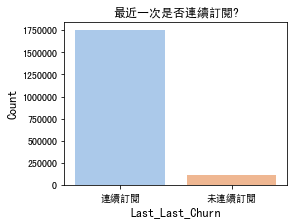

In [31]:
plt.figure(figsize=(4,3))
sns.countplot(x="last_last_churn", data=ft_last_last_churn, palette = "pastel")
plt.ylabel('Count', fontsize=12)
plt.xlabel('Last_Last_Churn', fontsize=12)
plt.xticks(np.arange(2), ('連續訂閱', '未連續訂閱'))
plt.title("最近一次是否連續訂閱?", fontsize=12)
plt.show()

##### 製作前一次自動續約last_auto_renew特徵

In [32]:
# 定義前一次是否自動續約
def last_last_renew(df):
    ft_last_auto_renew = df[['msno','is_auto_renew']].groupby(by=['msno'],as_index=False).head(1)
    ft_last_auto_renew.rename(columns={'is_auto_renew':'last_auto_renew'}, inplace=True)
    return ft_last_auto_renew

In [33]:
ft_last_auto_renew = last_last_renew(KKboxTransac)
ft_last_auto_renew.head()

,msno,last_auto_renew
0,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,1
1,AZtu6Wl0gPojrEQYB8Q3vBSmE2wnZ3hi1FbK1rQQ0A4=,1
2,UkDFI97Qb6+s2LWcijVVv4rMAsORbVDT2wNXF0aVbns=,1
3,M1C56ijxozNaGD0t2h68PnH2xtx5iO5iR2MVYQB6nBI=,1
4,yvj6zyBUaqdbUQSrKsrZ+xNDVM62knauSZJzakS9OW4=,1


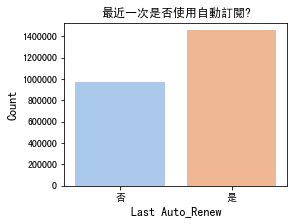

In [34]:
plt.figure(figsize=(4,3))
sns.countplot(x="last_auto_renew", data=ft_last_auto_renew, palette = "pastel")
plt.ylabel('Count', fontsize=12)
plt.xlabel('Last Auto_Renew', fontsize=12)
plt.xticks(np.arange(2), ('否','是'))
plt.title("最近一次是否使用自動訂閱?", fontsize=12)
plt.show()

##### 製作特徵獲得折扣次數is_disount

In [35]:
def is_discount(df):
    ft_discount = df[['msno', 'plan_list_price', 'actual_amount_paid']]
    ft_discount['discount'] = ft_discount['plan_list_price'] - ft_discount['actual_amount_paid']
    ft_discount['is_discount'] = ft_discount.discount.apply(lambda x: 1 if x > 0 else 0)
    ft_discount = ft_discount.groupby('msno', as_index=False)['is_discount'].count()
    return ft_discount

In [36]:
ft_isdiscount = is_discount(KKboxTransac)
ft_isdiscount.head()

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,msno,is_discount
0,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,1
1,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,2
2,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,5
3,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,21
4,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,27


##### 製作特徵平均每日花費amount_per_day

In [37]:
def amount_per_day(df):
    ft_amount_per_day = df[['msno', 'actual_amount_paid', 'payment_plan_days']]
    # 去掉payment_plan_days為0的欄位
    ft_amount_per_day = ft_amount_per_day[ft_amount_per_day['payment_plan_days'] != 0]
    # 計算平均每天花費金額
    ft_amount_per_day['amount_per_day'] = ft_amount_per_day['actual_amount_paid'] / ft_amount_per_day['payment_plan_days']
    # 重新選取欄位
    ft_amount_per_day = ft_amount_per_day[['msno', 'amount_per_day']]
    # 合併msno，並做amount_per_day平均
    ft_amount_per_day = ft_amount_per_day.groupby('msno', as_index=False)['amount_per_day'].mean()
    return ft_amount_per_day

In [38]:
ft_amount_per_day = amount_per_day(KKboxTransac)
print(ft_amount_per_day.shape)
ft_amount_per_day = ft_amount_per_day.dropna()
ft_amount_per_day.head()

(2426143, 2)


,msno,amount_per_day
0,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,0.00
1,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,4.20
2,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,3.30
3,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,4.94
4,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,4.97


##### 製作特徵總會員日membership_days

In [39]:
def membership_days(df):
    ft_membership_days = df[['msno', 'trans_date', 'mem_expire_date']]
    ft_membership_days['membership'] = ft_membership_days['mem_expire_date'] - ft_membership_days['trans_date']
    ft_membership_days['membership_days'] = ft_membership_days['membership'] / np.timedelta64(1,'D')
    ft_membership_days = ft_membership_days[['msno', 'membership_days']]
    ft_membership_days = ft_membership_days.groupby('msno', as_index=False)['membership_days'].sum()
    return ft_membership_days

In [40]:
ft_membership_days = membership_days(KKboxTransac)
print(ft_membership_days.shape)
ft_membership_days.head()

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


(2426143, 2)


,msno,membership_days
0,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,5.00
1,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,881.00
2,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,150.00
3,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,1031.00
4,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,821.00


##### 製作老客戶longtime_user(定義總時間一年以上)

In [41]:
def longtime_user(df):
    ft_membership_days = df[['msno', 'trans_date', 'mem_expire_date']]
    ft_membership_days['membership'] = ft_membership_days['mem_expire_date'] - ft_membership_days['trans_date']
    ft_membership_days['membership_days'] = ft_membership_days['membership'] / np.timedelta64(1,'D')
    # 取得總會員天數
    ft_longtime_user = ft_membership_days[['msno', 'membership_days']]
    # 合併同一user
    ft_longtime_user = ft_longtime_user.groupby('msno', as_index=False)['membership_days'].sum()
    # 定義longtime_user為超過365天者為1，未滿為0
    ft_longtime_user['longtime_user'] = (((ft_longtime_user['membership_days'] / 365).astype(int)) > 1).astype(int)
    # 僅選擇longtime_user欄位
    ft_longtime_user = ft_longtime_user[['msno', 'longtime_user']]
    return ft_longtime_user

In [42]:
ft_longtime_user = longtime_user(KKboxTransac)
print(ft_longtime_user.shape)
ft_longtime_user.head()

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


(2426143, 2)


,msno,longtime_user
0,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,0
1,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,1
2,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0
3,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,1
4,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,1


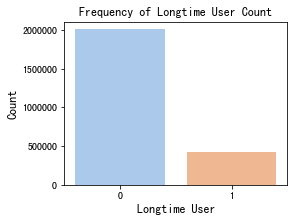

In [43]:
plt.figure(figsize=(4,3))
sns.countplot(x="longtime_user", data=ft_longtime_user, palette = "pastel")
plt.ylabel('Count', fontsize=12)
plt.xlabel('Longtime User', fontsize=12)
plt.title("Frequency of Longtime User Count", fontsize=12)
plt.show()

---

In [44]:
# 合併進連續/非連續訂閱者特徵last_last_churn
KKboxTrainMembersTransac = pd.merge(KKboxTrainMembers, ft_last_last_churn, how='inner', on=['msno'])

In [45]:
# 合併進自動續約last_auto_renew
KKboxTrainMembersTransac = pd.merge(KKboxTrainMembersTransac, ft_last_auto_renew, how='inner', on=['msno'])

In [46]:
# 合併折扣次數is_discount
KKboxTrainMembersTransac = pd.merge(KKboxTrainMembersTransac, ft_isdiscount, how='inner', on=['msno'])

In [47]:
# 合併每日平均花費amount_per_day
KKboxTrainMembersTransac = pd.merge(KKboxTrainMembersTransac, ft_amount_per_day, how='inner', on=['msno'])

In [48]:
# 合併老客戶longtime_user
KKboxTrainMembersTransac = pd.merge(KKboxTrainMembersTransac, ft_longtime_user, how='inner', on=['msno'])

---

In [49]:
print(KKboxTrainMembersTransac.shape)
KKboxTrainMembersTransac.head()

(767924, 12)


,msno,is_churn,city,bd,gender,registered_via,registration_init_time,last_last_churn,last_auto_renew,is_discount,amount_per_day,longtime_user
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1,18,36,0,9,2005-04-06,1,0,2,2.48,0
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,10,38,1,9,2005-04-07,0,1,23,4.99,1
2,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,10,38,1,9,2005-04-07,0,1,23,4.99,1
3,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1,11,27,0,9,2005-10-16,0,1,10,4.97,0
4,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1,13,23,0,9,2005-11-02,1,0,3,3.11,0


In [50]:
KKboxTrainMembersTransac.isnull().sum()

msno                      0
is_churn                  0
city                      0
bd                        0
gender                    0
registered_via            0
registration_init_time    0
last_last_churn           0
last_auto_renew           0
is_discount               0
amount_per_day            0
longtime_user             0
dtype: int64

---

In [124]:
# 存成csv
# KKboxTrainMembersTransac.to_csv('KKboxTrainMembersTransac.csv',index=False,header=True)

---

### 針對數據不平衡另外製作平衡資料集

由於資料集筆數超過10萬筆，故採用大樣本隨機抽樣方式進行欠採樣

In [53]:
def imbalance_random_sampling(df):
    # 取出特徵is_churn為流失(1)與非流失(0)的數據集
    df_notchurn = df[df['is_churn'] == 0]
    df_churn = df[df['is_churn'] == 1]
    # 因為要對數據量較多的一方進行隨機抽樣(這邊是notchurn數據量較多，並取得與churn數據量差不多的n)
    df_notchurn_change = df_notchurn.sample(n=78600)
    # 合併churn與notchurn欄位
    df_after = pd.concat([df_churn, df_notchurn_change], axis=0)
    df_after.sort_values(by=['msno','registration_init_time'],inplace=True)
    return df_after

In [54]:
KKboxTrainMembersTransacBalance = imbalance_random_sampling(KKboxTrainMembersTransac)

In [55]:
print(len(KKboxTrainMembersTransacBalance[KKboxTrainMembersTransacBalance['is_churn'] == 1]))
print(len(KKboxTrainMembersTransacBalance[KKboxTrainMembersTransacBalance['is_churn'] == 0]))

78637
78600


In [56]:
# 存成csv
KKboxTrainMembersTransacBalance.to_csv('KKboxTrainMembersTransacBalance.csv',index=False,header=True)